In [54]:
## IT'S DANGEROUS TO GO ALONE! TAKE THIS:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
#...that should be a good start

The cleaning, reformatting, and exploratory analysis are behind us and our data, 'soil', is ready to be used in modeling. 
The goal of our modeling is to predict a binary class of "in drought" or "not in drought". This is contained in our target variable, 'in_drought', where 1's are the positive, 'in_drought' class and 0's are the 'not in drought' class.

We will be attempting the following classification models using a full training and validation set from our data to make class predictions:

   * Logistic Regression
       - We will start with the default settings to set a baseline, and can optimize from there.
   * Decision Tree Classifier
       - We will use the defaults at first and similar to the LogReg we can iterate on our results.
   * Random Forest Classifier
       - Again, a test run with default followed by some optimization.
   * Gradient Boosting Classifier
       - We will employ a more exhaustive Grid Search and Cross-Validation to optimize our results.

As a reminder, we begain this project with the assumption that we can predict drought using data related to weather and conventional agricultural inputs, operationally defined using the cost of those inputs. Our data related to drought was reported at the weekly, county level. 

We can refer to our observations of "in drought" or "not in drought" as *county-weeks*: the observed county *is* or *is not* in drought for the observed week. Our drought data included the date for the county-week observations and we have split these dates into Year, Month, and Day data. We initially had data for the State and County, which will be dropped in favor for the unique Latitude and Longitude for each county. 

Our Exploratory data analysis had some early signs of a potential connection between the rate of county-weeks in drought and states with higher agricultural activity--when we separated the 15 "Farmland" states that we would be analyzing and modeling we saw a 47% positive rate for observing drought in a county-week, a 10% increase compared to 37% seen for the United States as a whole.

The other insights worth keeping in mind before modeling are:


From the EDA, we know that we have some potential for multicollinearity for our logistic regression. We will separate our "label" variables FIPS, State, and County and we will drop the mintemp, avgtemp, Chem_operations, Fert_operations, and both the chem and fert yearly expense columns to avoid multicollinearity.

First, a quick double check of our data

In [55]:
#reading in our data
soil = pd.read_csv('data/soil.csv')
soil

,Date,FIPS,County,State,total_Sq_Mi,in_drought,Year,Month,monthly_precip,mintemp,...,yearly_chem_dollars,Chem_operations,Acres_operated,Operations,yearly_fert_dollars,Fert_operations,Lat,Long,yearly_conv_input_exp,Day
0,2017-12-26,5007,Benton County,AR,873.97,1,2017,12,1.92,28.8,...,1072000.0,702.0,243753.0,1936,2967000.0,798.0,36.337825,-94.256187,4039000.0,26
1,2017-12-19,5007,Benton County,AR,873.97,1,2017,12,1.92,28.8,...,1072000.0,702.0,243753.0,1936,2967000.0,798.0,36.337825,-94.256187,4039000.0,19
2,2017-12-12,5007,Benton County,AR,873.97,1,2017,12,1.92,28.8,...,1072000.0,702.0,243753.0,1936,2967000.0,798.0,36.337825,-94.256187,4039000.0,12
3,2017-12-05,5007,Benton County,AR,873.97,1,2017,12,1.92,28.8,...,1072000.0,702.0,243753.0,1936,2967000.0,798.0,36.337825,-94.256187,4039000.0,5
4,2017-11-28,5007,Benton County,AR,873.97,1,2017,11,1.58,40.7,...,1072000.0,702.0,243753.0,1936,2967000.0,798.0,36.337825,-94.256187,4039000.0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307016,2002-01-29,53029,Island County,WA,213.97,0,2002,1,3.90,36.6,...,85000.0,70.0,15018.0,348,135000.0,72.0,48.158436,-122.670500,220000.0,29
307017,2002-01-22,53029,Island County,WA,213.97,0,2002,1,3.90,36.6,...,85000.0,70.0,15018.0,348,135000.0,72.0,48.158436,-122.670500,220000.0,22
307018,2002-01-15,53029,Island County,WA,213.97,0,2002,1,3.90,36.6,...,85000.0,70.0,15018.0,348,135000.0,72.0,48.158436,-122.670500,220000.0,15
307019,2002-01-08,53029,Island County,WA,213.97,0,2002,1,3.90,36.6,...,85000.0,70.0,15018.0,348,135000.0,72.0,48.158436,-122.670500,220000.0,8


In [56]:
#a final check for nulls
soil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307021 entries, 0 to 307020
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   307021 non-null  object 
 1   FIPS                   307021 non-null  int64  
 2   County                 307021 non-null  object 
 3   State                  307021 non-null  object 
 4   total_Sq_Mi            307021 non-null  float64
 5   in_drought             307021 non-null  int64  
 6   Year                   307021 non-null  int64  
 7   Month                  307021 non-null  int64  
 8   monthly_precip         307021 non-null  float64
 9   mintemp                307021 non-null  float64
 10  maxtemp                307021 non-null  float64
 11  avgtemp                307021 non-null  float64
 12  yearly_chem_dollars    307021 non-null  float64
 13  Chem_operations        307021 non-null  float64
 14  Acres_operated         307021 non-nu

In [65]:
#reordering the dataframe
soil = soil[['Date', 'FIPS', 'County', 'State', 'total_Sq_Mi', 'in_drought', 'Year',
       'Month', 'Day', 'monthly_precip', 'mintemp', 'maxtemp', 'avgtemp',
       'yearly_chem_dollars', 'Chem_operations', 'Acres_operated',
       'Operations', 'yearly_fert_dollars', 'Fert_operations', 'yearly_conv_input_exp', 'Lat', 'Long']]
soil

,Date,FIPS,County,State,total_Sq_Mi,in_drought,Year,Month,Day,monthly_precip,...,avgtemp,yearly_chem_dollars,Chem_operations,Acres_operated,Operations,yearly_fert_dollars,Fert_operations,yearly_conv_input_exp,Lat,Long
0,2017-12-26,5007,Benton County,AR,873.97,1,2017,12,26,1.92,...,38.9,1072000.0,702.0,243753.0,1936,2967000.0,798.0,4039000.0,36.337825,-94.256187
1,2017-12-19,5007,Benton County,AR,873.97,1,2017,12,19,1.92,...,38.9,1072000.0,702.0,243753.0,1936,2967000.0,798.0,4039000.0,36.337825,-94.256187
2,2017-12-12,5007,Benton County,AR,873.97,1,2017,12,12,1.92,...,38.9,1072000.0,702.0,243753.0,1936,2967000.0,798.0,4039000.0,36.337825,-94.256187
3,2017-12-05,5007,Benton County,AR,873.97,1,2017,12,5,1.92,...,38.9,1072000.0,702.0,243753.0,1936,2967000.0,798.0,4039000.0,36.337825,-94.256187
4,2017-11-28,5007,Benton County,AR,873.97,1,2017,11,28,1.58,...,51.7,1072000.0,702.0,243753.0,1936,2967000.0,798.0,4039000.0,36.337825,-94.256187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307016,2002-01-29,53029,Island County,WA,213.97,0,2002,1,29,3.90,...,41.1,85000.0,70.0,15018.0,348,135000.0,72.0,220000.0,48.158436,-122.670500
307017,2002-01-22,53029,Island County,WA,213.97,0,2002,1,22,3.90,...,41.1,85000.0,70.0,15018.0,348,135000.0,72.0,220000.0,48.158436,-122.670500
307018,2002-01-15,53029,Island County,WA,213.97,0,2002,1,15,3.90,...,41.1,85000.0,70.0,15018.0,348,135000.0,72.0,220000.0,48.158436,-122.670500
307019,2002-01-08,53029,Island County,WA,213.97,0,2002,1,8,3.90,...,41.1,85000.0,70.0,15018.0,348,135000.0,72.0,220000.0,48.158436,-122.670500


In [66]:
#describe to check variance. 
soil.describe()

,FIPS,total_Sq_Mi,in_drought,Year,Month,Day,monthly_precip,mintemp,maxtemp,avgtemp,yearly_chem_dollars,Chem_operations,Acres_operated,Operations,yearly_fert_dollars,Fert_operations,yearly_conv_input_exp,Lat,Long
count,307021.000000,307021.000000,307021.000000,307021.000000,307021.000000,307021.000000,307021.000000,307021.000000,307021.000000,307021.000000,3.070210e+05,307021.000000,3.070210e+05,307021.000000,3.070210e+05,307021.000000,3.070210e+05,307021.000000,307021.000000
mean,27137.590197,819.490093,0.469737,2009.464115,6.468900,15.880383,2.968160,45.830625,68.392837,57.115290,5.885705e+06,360.308324,3.014529e+05,754.089300,8.760502e+06,406.364910,1.464621e+07,37.478721,-93.774843
std,15228.438813,900.642853,0.499084,5.600753,3.461377,8.801931,2.542033,17.077727,18.468828,17.664211,1.368996e+07,328.872289,2.791320e+05,609.302239,1.330175e+07,352.127376,2.634637e+07,5.092996,9.427255
min,5001.000000,46.720000,0.000000,2002.000000,1.000000,1.000000,0.000000,-8.500000,9.800000,0.700000,0.000000e+00,1.000000,7.000000e+00,3.000000,0.000000e+00,0.000000,1.000000e+03,25.601043,-123.980990
25%,17017.000000,454.360000,0.000000,2002.000000,4.000000,8.000000,1.160000,33.200000,55.700000,44.600000,6.380000e+05,145.000000,1.159300e+05,354.000000,1.375000e+06,171.000000,2.123000e+06,33.240660,-97.653997
50%,20165.000000,637.750000,0.000000,2007.000000,7.000000,16.000000,2.450000,47.100000,71.500000,59.300000,2.796000e+06,288.000000,2.538630e+05,619.000000,4.809000e+06,335.000000,7.631000e+06,38.021451,-93.242723
75%,37101.000000,902.350000,1.000000,2012.000000,10.000000,24.000000,4.120000,59.800000,83.700000,71.800000,7.074000e+06,487.000000,4.148870e+05,972.000000,1.170800e+07,551.000000,1.899100e+07,41.187925,-87.402172
max,55141.000000,20117.770000,1.000000,2017.000000,12.000000,31.000000,46.040000,82.800000,108.500000,95.700000,3.547430e+08,4935.000000,3.777285e+06,6687.000000,2.698370e+08,5184.000000,6.245800e+08,48.842653,-75.767536


In [67]:
#double checking the Target variable's ratio
print(f'The positive "in drought" classification makes up {round(soil["in_drought"].value_counts()[1]/(soil["in_drought"].value_counts()[1]+soil["in_drought"].value_counts()[0]),2)*100}% of our target variable')

The positive "in drought" classification makes up 47.0% of our target variable


We seem to have a great deal of variance in our data, so we will likely use the minmax scaler for the first pass with our logistic regression. We can move on to creating a dataframe with only the features we will use in modeling, removing:

* Date
* FIPS
* State
* County
* mintemp
* avgtemp
* Chem_operations
* Fert_operations
* yearly_chem_dollars
* yearly_fert_dollars

We can label this 'soilmodel'. We will write this to a csv for safe keeping. From there we can work on setting up a full Train and test split for our data, and a Train and Validate split out of the full Train set.

In [68]:
#checking the drop first
soil.drop(columns=(['Date',
                    'FIPS',
                    'State',
                    'County',
                    'mintemp',
                    'avgtemp',
                    'Chem_operations',
                    'Fert_operations',
                    'yearly_chem_dollars',
                    'yearly_fert_dollars']))

,total_Sq_Mi,in_drought,Year,Month,Day,monthly_precip,maxtemp,Acres_operated,Operations,yearly_conv_input_exp,Lat,Long
0,873.97,1,2017,12,26,1.92,48.9,243753.0,1936,4039000.0,36.337825,-94.256187
1,873.97,1,2017,12,19,1.92,48.9,243753.0,1936,4039000.0,36.337825,-94.256187
2,873.97,1,2017,12,12,1.92,48.9,243753.0,1936,4039000.0,36.337825,-94.256187
3,873.97,1,2017,12,5,1.92,48.9,243753.0,1936,4039000.0,36.337825,-94.256187
4,873.97,1,2017,11,28,1.58,62.7,243753.0,1936,4039000.0,36.337825,-94.256187
...,...,...,...,...,...,...,...,...,...,...,...,...
307016,213.97,0,2002,1,29,3.90,45.6,15018.0,348,220000.0,48.158436,-122.670500
307017,213.97,0,2002,1,22,3.90,45.6,15018.0,348,220000.0,48.158436,-122.670500
307018,213.97,0,2002,1,15,3.90,45.6,15018.0,348,220000.0,48.158436,-122.670500
307019,213.97,0,2002,1,8,3.90,45.6,15018.0,348,220000.0,48.158436,-122.670500


In [69]:
#and creating a new dataframe for modeling
soilmodel = soil.drop(columns=(['Date',
                                'FIPS',
                                'State',
                                'County',
                                'mintemp',
                                'avgtemp',
                                'Chem_operations',
                                'Fert_operations',
                                'yearly_chem_dollars',
                                'yearly_fert_dollars']))

In [70]:
#taking a look
soilmodel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307021 entries, 0 to 307020
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   total_Sq_Mi            307021 non-null  float64
 1   in_drought             307021 non-null  int64  
 2   Year                   307021 non-null  int64  
 3   Month                  307021 non-null  int64  
 4   Day                    307021 non-null  int64  
 5   monthly_precip         307021 non-null  float64
 6   maxtemp                307021 non-null  float64
 7   Acres_operated         307021 non-null  float64
 8   Operations             307021 non-null  int64  
 9   yearly_conv_input_exp  307021 non-null  float64
 10  Lat                    307021 non-null  float64
 11  Long                   307021 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 28.1 MB


In [71]:
#writing to CSV and then commenting out the write function
soilmodel.to_csv('soilmodel.csv', index=False)

## Train, Validate, and Test sets
Our target variable is well balanced with 47% of our observations indicating 'in drought' and 53% indicating 'not in drought', so we have some freedom to use a larger portion of our data for our fulltrain set, to be divided up into train and validate sets. We will use the stratify parameter in the train_test_split function to ensure that our target variable's ratio of 47% to 53% is carried out in each split we make. 

We can split our data as follows:

**20%** of the total data in the **test** sets:
 * X_test - All of the columns *except* **in_drought** in our "soilmodel" dataframe
 * y_test - The **in_drought** column in our "soilmodel" dataframe

**80%** of the total data in the **fulltrain** sets:
 * X_fulltrain - All of the columns *except* **in_drought** in our "soilmodel" dataframe
 * y_fulltrain - The **in_drought** column in our "soilmodel" dataframe

    A split within the **fulltrain** data will give us a train and validate set to use for hyperparameter adjustments. We will split the **fulltrain** data **75% by 25%** leaving us with:
        
    **20%** of the total data in the **validate** sets:
      * X_validate - One third of the data from all of the columns *except* **in_drought** in our "soilmodel" dataframe 
      * y_validate - One third of the data from only the **in_drought** column in our "soilmodel" dataframe
    
    **60%** of the total data in the **train** sets:
      * X_train - Two thirds of the data from all of the columns *except* **in_drought** in our "soilmodel" dataframe
      * y_train - Two thirds of the data from only the **in_drought** column in our "soilmodel" dataframe

In [72]:
#setting up our x and y
X = soilmodel.drop(columns=['in_drought'])
y = soilmodel['in_drought']

print(f' The number of rows and columns in X is {X.shape}')
print(f' The number of rows in y is {y.shape}')

 The number of rows and columns in X is (307021, 11)
 The number of rows in y is (307021,)


In [73]:
#setting up the first split to make our fulltrain and test sets, 80/20 with stratify
X_fulltrain, X_test, y_fulltrain, y_test = train_test_split(
    X, y, stratify = y, test_size=0.2, random_state=1337)

print(f' The number of rows and columns in X_fulltrain is {X_fulltrain.shape}')
print(f' The number of rows and columns in y_fulltrain is {y_fulltrain.shape}\n')

print(f' The number of rows and columns in X_test is {X_test.shape}')
print(f' The number of rows and columns in y_test is {y_test.shape}')

 The number of rows and columns in X_fulltrain is (245616, 11)
 The number of rows and columns in y_fulltrain is (245616,)

 The number of rows and columns in X_test is (61405, 11)
 The number of rows and columns in y_test is (61405,)


In [74]:
#checking the ratios
print(f'y_test ratio: {y_test.value_counts()[1]/(y_test.value_counts()[1]+y_test.value_counts()[0])}')
print(f'y_fulltrain ratio: {y_fulltrain.value_counts()[1]/(y_fulltrain.value_counts()[1]+y_fulltrain.value_counts()[0])}')

y_test ratio: 0.46973373503786336
y_fulltrain ratio: 0.4697373135300632


In [75]:
#setting up the second split to make our train and validate sets, 80/20 with stratify
X_train, X_validate, y_train, y_validate = train_test_split(
    X_fulltrain, y_fulltrain, stratify = y_fulltrain, test_size=0.25, random_state=1337)

print(f' The number of rows and columns in X_train is {X_train.shape}')
print(f' The number of rows and columns in y_train is {y_train.shape}\n')

print(f' The number of rows and columns in X_validate is {X_validate.shape}')
print(f' The number of rows and columns in y_validate is {y_validate.shape}')

 The number of rows and columns in X_train is (184212, 11)
 The number of rows and columns in y_train is (184212,)

 The number of rows and columns in X_validate is (61404, 11)
 The number of rows and columns in y_validate is (61404,)


In [76]:
#checking the ratios
print(f'y_validate ratio: {y_validate.value_counts()[1]/(y_validate.value_counts()[1]+y_validate.value_counts()[0])}')
print(f'y_train ratio: {y_train.value_counts()[1]/(y_train.value_counts()[1]+y_train.value_counts()[0])}')

y_validate ratio: 0.46974138492606343
y_train ratio: 0.4697359563980631


## Logistic Regression
---
Our first model will be a Logistic Regression. The goal with this type of model is use our X variables relationship with the Target, **in_drought**. Logistic Regression should give us a nice baseline accuracy that we will try to improve on, both by tuning the Logistic Regression model itself and with our later models. 

We will improve our performance by scaling our data ahead of fitting it to the model. We observed a great deal of variation in the ranges seen in our data--scaling will capture the variance in our data without giving more weight to features that have larger absolute ranges.

In [77]:
#scaling the data
#instantiate minmax scaler
scaler = MinMaxScaler()
scaler.fit(X_train)

#transform the data with our scaler
logitX_train = scaler.transform(X_train)
logitX_validate = scaler.transform(X_validate)

In [79]:
#instantiate the Logistic Regression with a random state and defaults
logit_model = LogisticRegression(random_state=1337)

#fit the model
logit_model.fit(logitX_train, y_train)

#output the accuracy of the train and validate scores
print(f'Train Score: {logit_model.score(logitX_train, y_train)}')
print(f'Test Score: {logit_model.score(logitX_validate, y_validate)}')

Train Score: 0.6356589147286822
Test Score: 0.6352843462966582


It worked!

Just not very well. The model seems to be well fit, considering the train and test scores are almost equal. A score of 63.5 is a modest improvement on pure chance--16.5% improvement on a 47% chance of guessing a county-week observation being  in drought.

We have room to optimize the logistic regression and a good place to start is with the hyperparameter "C". In a Logistic Regression, C will determine the amount of regularization. C by default is equal to 1 and we will test variations by setting C to different powers of 10: .001, .01, .1, 1, 10, 100, 1000

In [161]:
#fitting to different levels of C
train_accs = []
validate_accs = []
C_list = [.001, .01, .1, 1, 10, 100, 1000]
for i in C_list:
    print(f"Working on my model with a C of {i}...", end="\r")
    # 1. Instantiate 
    Optlogit_model = LogisticRegression(C=i, random_state=1337)

    # 2. Fit (on the train set)
    Optlogit_model.fit(logitX_train, y_train)

    # 3. Score (on both sets)
    train_score = Optlogit_model.score(logitX_train, y_train)
    validate_score = Optlogit_model.score(logitX_validate, y_validate)
    
    # Add these to the lists
    train_accs.append(train_score)
    validate_accs.append(validate_score)

In [164]:
validate_accs

[0.5887238616376783,
 0.6252687121360172,
 0.6349586346166374,
 0.6352843462966582,
 0.6354309165526676,
 0.6354634877206696,
 0.6354146309686666]

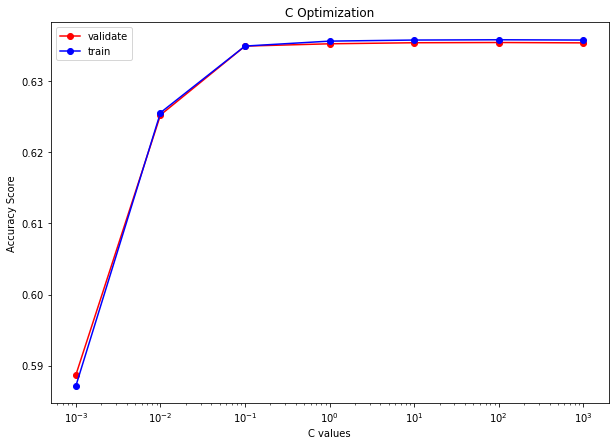

In [166]:
#plotting the accuracy scores at different max depths
plt.figure(figsize=(10,7))
plt.plot(C_list, validate_accs, color="red", label="validate", marker='o')
plt.plot(C_list, train_accs, color="blue", label="train", marker='o')
plt.ylabel("Accuracy Score")
plt.xlabel("C values")
plt.xscale('log')
plt.title("C Optimization")
plt.legend()
plt.show()

The best option for a C value appear to be the default of 1. We can try running our model with the full training and test data.

In [186]:
#using a C of 1
#scaling the data
#instantiate minmax scaler
scaler = MinMaxScaler()
scaler.fit(X_fulltrain)

#transform the data with our scaler
logitX_fulltrain = scaler.transform(X_fulltrain)
logitX_test = scaler.transform(X_test)

#instantiate the Logistic Regression with a random state and a C of 1
logit_model_test = LogisticRegression(C=1, random_state=1337)

#fit the model
logit_model_test.fit(logitX_fulltrain, y_fulltrain)

#output the accuracy of the train and validate scores
print(f'Train Score: {logit_model_test.score(logitX_fulltrain, y_fulltrain)}')
print(f'Test Score: {logit_model_test.score(logitX_test, y_test)}')

Train Score: 0.635280274900658
Test Score: 0.6378959368129631


We are not seeing much improvement from the first model but that is primarily because our tuning did not change the hyperparameters we were using. The results are at least consistent, albeit with lackluster accuracy. Before moving on to a Decision Tree model we can take a look at the coefficients that were used in the model and see what factor had more weight in our model.

In [190]:
#calling the coefficient values
logit_model_test.coef_[0]

array([ 3.11639644, -0.20787261,  0.4954668 ,  0.01939834, -9.3288497 ,
        1.11759682, -1.75053777, -1.99277881,  3.63981069, -1.16972124,
        0.44185759])

In [191]:
#converting the nested list in an array to a list
coef_list = logit_model_test.coef_[0]
coef_list

array([ 3.11639644, -0.20787261,  0.4954668 ,  0.01939834, -9.3288497 ,
        1.11759682, -1.75053777, -1.99277881,  3.63981069, -1.16972124,
        0.44185759])

In [192]:
#setting up a dataframe
coef_df = pd.DataFrame(
    {"Feature":X_test.columns,
     "LogReg Coefficients": coef_list})

coef_df.sort_values(by="LogReg Coefficients", ascending=False, ignore_index=True)

,Feature,LogReg Coefficients
0,yearly_conv_input_exp,3.639811
1,total_Sq_Mi,3.116396
2,maxtemp,1.117597
3,Month,0.495467
4,Long,0.441858
5,Day,0.019398
6,Year,-0.207873
7,Lat,-1.169721
8,Acres_operated,-1.750538
9,Operations,-1.992779


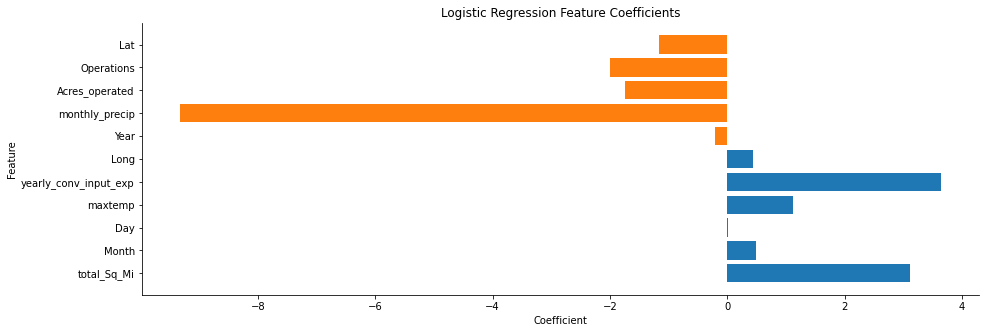

In [193]:
#graphing our coeffs
plt.figure(figsize=(15,5))
positive_coefs = coef_df[coef_df['LogReg Coefficients'] >=0]
negative_coefs = coef_df[coef_df['LogReg Coefficients'] < 0]
plt.barh(positive_coefs['Feature'], positive_coefs['LogReg Coefficients'])
plt.barh(negative_coefs['Feature'], negative_coefs['LogReg Coefficients'])
plt.title('Logistic Regression Feature Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
sns.despine()
plt.show()

The strongest coefficient for predicting drought is monthly precipitation, with a negative relationship indication that as precipitation decreases the odds of the model predicting drought are increased. Second is a positive relationship between conventional agricultural input expenses and a positive prediction of drought. This matches our initial assumptions that there is a relationship between the presence of conventional agriculture and drought.

The coefficients encouragingly match our initial assumptions and some intuition regarding drought--unfortunately the accuracy score of the model is not much better than pure chance. We would predict drought conditions for a county-week 47% of the time and improving on that guess by 16% with our Logistic Regression is not ideal.

We can move on to our Decision Tree modeling.

## Decision Tree
---
Our Logistic Regression model accuracy was a bit disappointing, but it appears to score very consistently when we applied it to our test data. We will likely see the *opposite* effect in our decision tree model--they tend to overfit and generalize poorly.

Decision Trees iteratively split our data in two, maximizing the separation between classes with each split. Decision trees are not affected by the different scales of variance in the data and do not need scaling.

We will run the decision tree model with default setting initially, with no limit to the depth of the tree and no minimum number of samples for it to group together.

In [80]:
#instantiate
DT_model = DecisionTreeClassifier()

#fit
DT_model.fit(X_train, y_train)

#score
print(f'Train Score: {DT_model.score(X_train, y_train)}')
print(f'Validate Score: {DT_model.score(X_validate, y_validate)}')

Train Score: 1.0
Validate Score: 0.949547260764771


It also worked! Lets see how deep the tree went, though...

In [81]:
DT_model.get_depth()

31

A depth of 31 is likely to overfit our data and generalize poorly to new data. We can rerun the model with a depth of 5, per the suggetions from the Scikit-Learn documentation, and see how the performance changes.

In [82]:
#instantiate 2nd try with a max depth of 5
DT_model2 = DecisionTreeClassifier(max_depth=5)

#fit
DT_model2.fit(X_train, y_train)

#score
print(f'Train Score: {DT_model2.score(X_train, y_train)}')
print(f'Validate Score: {DT_model2.score(X_validate, y_validate)}')

Train Score: 0.7209085184461381
Validate Score: 0.7221190801902156


The second fit with a depth of 5 is lower than our initial attempt but still a 25% improvement on a pure chance guess-- **72% versus 47%.**

Our first model is overfit--a training accuracy of 100% with a validation of 95% is not a huge gap, but we may be able to trade having a slightly lower accuracy on the training set in exchange for a pair of train and validate scores that are within a percentage point or two of each other.

Knowing that the max_depth topped out at 31 with the default values, we can try to dial in a depth below 31 that is not as overfit.

In [84]:
#fitting depths up to 31
train_accs = []
validate_accs = []
depth = range(1, 32)
for i in depth:
    print(f"Working on my model with {i} depth...", end="\r")
    # 1. Instantiate 
    DT_optdepth = DecisionTreeClassifier(max_depth=i)

    # 2. Fit (on the train set)
    DT_optdepth.fit(X_train, y_train)

    # 3. Score (on both sets)
    train_score = DT_optdepth.score(X_train, y_train)
    validate_score = DT_optdepth.score(X_validate, y_validate)
    
    # Add these to the lists
    train_accs.append(train_score)
    validate_accs.append(validate_score)

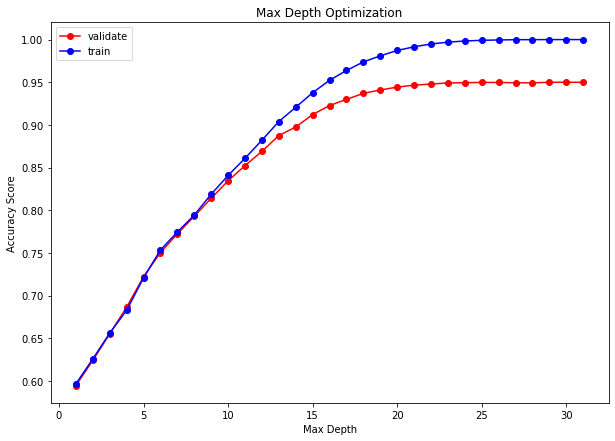

In [85]:
#plotting the accuracy scores at different max depths
plt.figure(figsize=(10,7))
plt.plot(depth, validate_accs, color="red", label="validate", marker='o')
plt.plot(depth, train_accs, color="blue", label="train", marker='o')
plt.ylabel("Accuracy Score")
plt.xlabel("Max Depth")
plt.title("Max Depth Optimization")
plt.legend()
plt.show()

We see the scores diverging around a depth of 9 or 10 and the gap widens consistently until both scores level off around a depth of 20 or 21. We can slice the train and validation scores at these depths and replot them.

In [92]:
#setting up list slices that should let us see the depths between 9 and 21
validate_accs_zoomed = validate_accs[8:22]
train_accs_zoomed = train_accs[8:22]
depth_zoomed = depth[8:22]

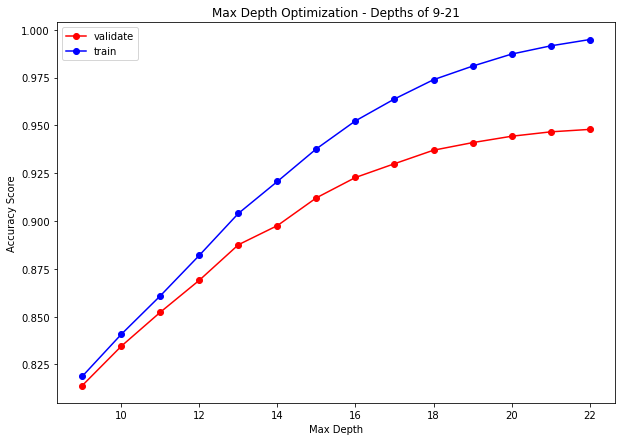

In [93]:
#plot the graph, but focused on the 'elbow' we are seeing in our scores
plt.figure(figsize=(10,7))
plt.plot(depth_zoomed, validate_accs_zoomed, color="red", label="validate", marker='o')
plt.plot(depth_zoomed, train_accs_zoomed, color="blue", label="train", marker='o')
plt.ylabel("Accuracy Score")
plt.xlabel("Max Depth")
plt.title("Max Depth Optimization - Depths of 9-21")
plt.legend()
plt.show()

Even after zooming in on the 'elbow' we are seeing in the full graph, there is still not a visually clear bend to point to. In the interest of generalizability, we can err toward a smaller max depth and slightly lower accuracy--a depth of 14 seems appropriate.

In [104]:
print(f'With a depth of 14, the train score is {round(train_accs[13],2)*100}%\n\
and the validate score is {round(validate_accs[13],2)*100}%.')

With a depth of 14, the train score is 92.0%
and the validate score is 90.0%.


Having a 92% on train and 90% on validate is well fit and hopefully our depth of 14 will generalize well on our test data. Lets run our test data with a depth of 14 on the fulltrain and test sets.

In [106]:
#instantiate
DT_modeltest = DecisionTreeClassifier(max_depth=14)

#fit
DT_modeltest.fit(X_fulltrain, y_fulltrain)

#score
print(f'Full Train Score: {DT_modeltest.score(X_fulltrain, y_fulltrain)}')
print(f'Test Score: {DT_modeltest.score(X_test, y_test)}')

Full Train Score: 0.9186453651227933
Test Score: 0.902043807507532


Our model generalized well on our test data, outputting scores that when rounded are equal to our optimized train and validate scores. We can get some additional information on our model's performance by checking the accuracy in a confusion matrix and looking at the Precision and Recall of the model.

In [107]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Get class predictions
y_pred = DT_modeltest.predict(X_test)

# Generate a basic confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[30172,  2389],
       [ 3626, 25218]], dtype=int64)

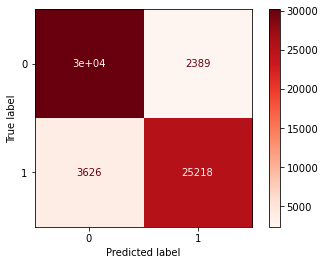

In [108]:
#plotting the confusion matrix
plot_confusion_matrix(DT_modeltest, X_test, y_test, cmap='Reds');

In [109]:
#true negatives, the top left at 30172
tn = cf_matrix[0,0]

#false negatives, bottom left at 3626
fn = cf_matrix[1,0]

#true positives, bottom right at 25218
tp = cf_matrix[1,1]

#false positives, top right at 2389
fp = cf_matrix[0,1]

In [114]:
#getting our precision score
precision = tp/(tp+fp)

print(f"Our model's Precision is {tp}/{tp+fp}, or {round(precision*100, 2)}%")

Our model's Precision is 25218/27607, or 91.35%


In [115]:
#getting our recall score
precision = tp/(tp+fn)

print(f"Our model's Recall is {tp}/{tp+fn}, or {round(precision*100, 2)}%")

Our model's Recall is 25218/28844, or 87.43%


The final Decision Tree model is overall scoring well, with our Accuracy, Precision, and Recall scores all near 90%.

To summarize, our model **accurately classifies instances where the observed county is in a week of drought 90% of the time.** The model **identifies 87% of the weeks** that are **in fact in drought** as a county-week in drought. Finally, our model is precise--**91% of the county-weeks that it predicted as being in drought are in fact in drought.

Having our accuracy, precision, and recall around 90% is a good place to start, especially considering the relative simplicity of the model. We will test at least one other type of model-- a Random Forest ensemble model-- but first we can take a look at the underlying decisions that our Decision Tree made in its classification.

We can check the tree plot's initial splits to see what features had a strong impact in dividing the data.

In [116]:
#importing plot_tree
from sklearn.tree import plot_tree

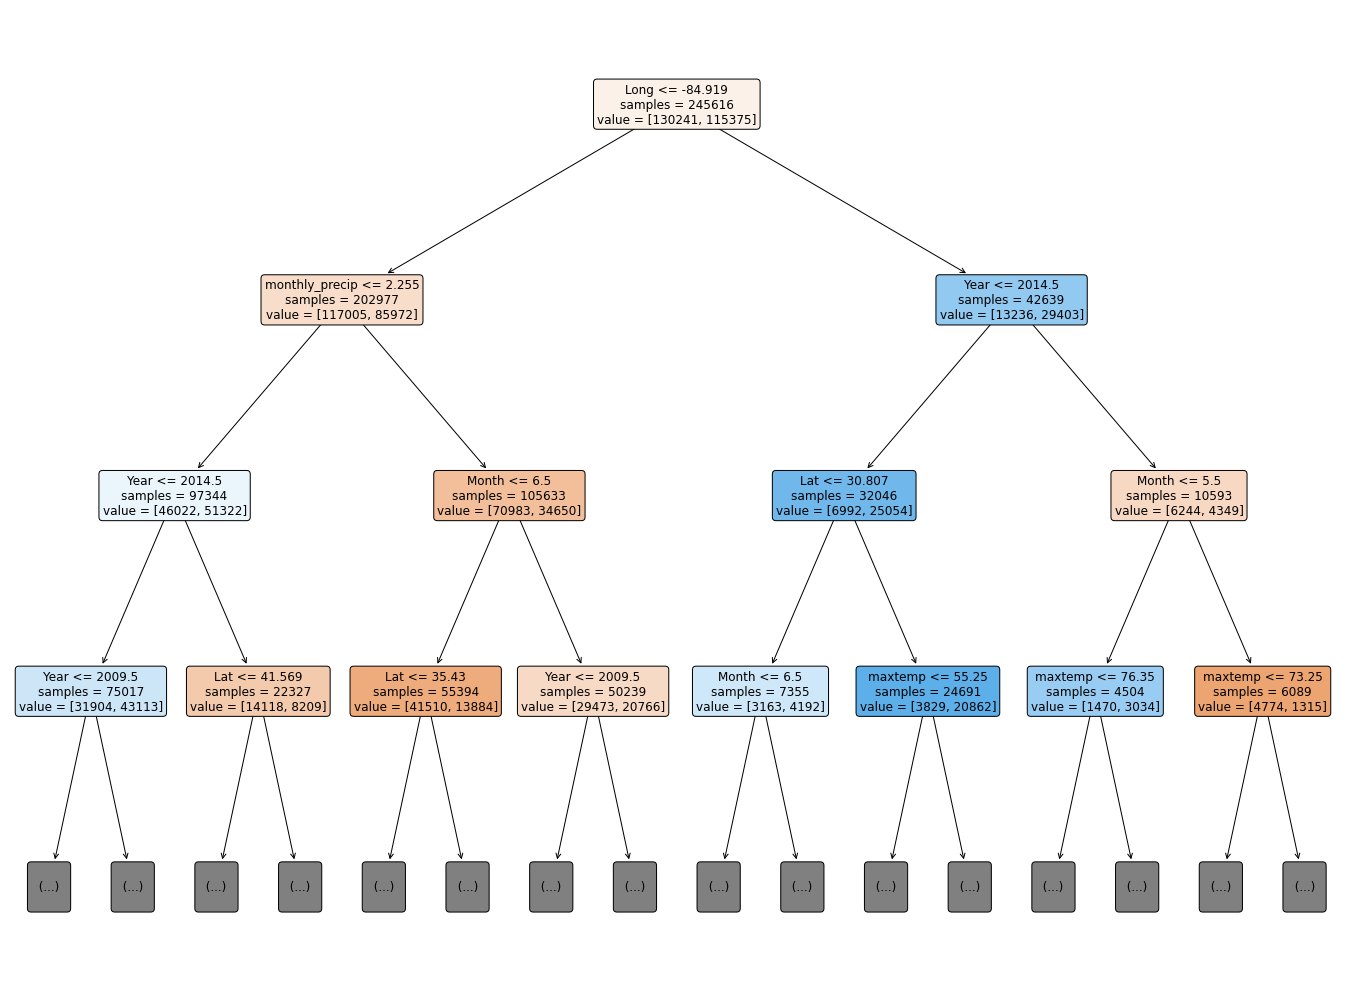

In [152]:
#Plotting the first, second, and third splits in the data
fig, ax = plt.subplots(figsize=(24,18))

plot_tree(DT_modeltest,
          max_depth=3,
          feature_names=X_test.columns,
          rounded=True,
          impurity=False,
          filled=True,
          ax=ax,
          fontsize=12);

The splits that move to the left of a leaf node are the observations that are 'True' for that leaf node. To break down the way the leaf nodes branched, we can interpret the leaf nodes for the first few levels of the decision tree. For each node, we can not what direction the classifications were *mostly* sent in.

   * **First level and node:** samples with longitudes less than or equal to -84.919. *"in drought" to the left, "not in drought" to the right*
   
       -This longitude is roughly the western border of the state Georgia. All of the counties to the east of this would be in most of Georgia, most of florida, and all of North Carolina. These three states mostly split to the right. The remaining 12 states and some of Georgia and Florida split to the left.
---
   
   * **Second level, left node:** samples with monthly precipitation of less than 2.255 inches of rain. *"in drought" to the left, "not in drought" to the right*
   
        -This could theoretically include any county-week observations roughly west of Georgia. County-week observations with less than or equal monthly precipitation went left, county-week observations with more precipitation went right.
        
        
   * **Second level, right node:** samples in years less than or equal to 2014.5. *"not in drought" to the left, "in drought" to the right*
       
        -This would be 2002, 2007, and 2012 splitting to the left and 2017 splitting to the right, and would be counties in Florida, Georgia, and North Carolina
---
   
   * **Third level, far left node:** samples in years less than or equal to 2014.5. *"not in drought" to the left, "in drought" to the right*
   
        -This split was used previously, so likely has some significance. Again, this would be 2002, 2007, and 2012 splitting to the left and 2017 splitting to the right, and would include mainly counties *outside of* Florida, Georgia, and North Carolina
        
        
   * **Third level, middle left node:** samples in months less than or equal to 6.5 (so January through June). *"in drought" to the left, "not in drought" to the right*
   
        -This is still for the county-weeks that are largely outside Georgia, Florida, and North Carolina. The observations from the first half of the year in this subset tend to have more drought.
        
        
   * **Third level, middle right node:** samples with latitudes less than 30.807 (roughly south of the Georgia/Florida border). *"in drought" to the left, "not in drought" to the right*
   
        -This split seems to mainly be in place to separate Georgia and Florida along this branch.
   
   
   * **Third level, far right:** samples in months less than or equal to 5.5 (so January through May). *"not in drought" to the left, "in drought" to the right*
    
       -These samples are still generally Georgia, Florida, and North Carolina and the months *after* May had more drought.
---

   * **Fourth level, general observations:**
   Year and Latitude both appear twice in the left-side nodes, Month appears once on the right half and otherwise the remaining splits are based on the maximum temperature. These may be smaller divisions in a relative sense, but Year, Latitude and maximum temperature 
---

In general, our data is being split early on with geographic and year data. This hints at differences between years or times of year, and geographic location. We can move on to set up a Random Forest, but the background in these initial splits sheds some light on the most importance factors influencing our "in drought" condition.

Unfortunately, Conventional Agriculture inputs-- our combined Chemical and Fertilizer input expenses-- is not making an appearance in any of these early splits. 

One piece that does not match expectations is that Georgia was initially included in the 3 states that had more observations of "not in drought". From our EDA, we know that Georgia had the highest rate of drought out of all 15 states.

## Random Forest
---
To build off of our Decision Tree model, we can set up a Random Forest ensemble model.
A Random Forest model is, essentially, a collection of Decision Trees that are each given a portion of the total training data. These Decision trees will split the observations into node like usual. Once all of the trees have hit their maximum depth their predictions are averaged.

We will start with the default set-up for our first RF model and use our train and validate sets. Then we can try some basic optimization and go from there.

In [121]:
from sklearn.ensemble import RandomForestClassifier
#running with the default set up:
# no limit to the max depth and 100 estimators ("Trees")
#instantiate
RF_model = RandomForestClassifier()

#fit
RF_model.fit(X_train, y_train)

#score
print(f'Train Score: {RF_model.score(X_train, y_train)}')
print(f'Validate Score: {RF_model.score(X_validate, y_validate)}')

Train Score: 0.9999945714719997
Validate Score: 0.9544003647970816


This model is likely overfit - the same risk of overfitting that we have with a Decision Tree still applies for a Random forest. We can check the hyperparameters that were used in the model, but we are not able to see the max depth that was used as *there could be a different depth for each of the 100 "trees" in the model*. Similar to the optimization we performed for our Decision Tree, we can iterate through different numbers of estimators and see how our train and validate accuracies change with the hyperparameter.

In [122]:
#checking the parameters used in the first pass with the RF model
RF_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We know that using 100 estimators resulted in a highly accurate (and most certainly highly overfit...) model. We can work our way up to 100 estimators, or "trees", and then graph the scores of those iterations. We will start with 5 estimators and increase by 5 unitl we hit 100.

In [131]:
#fitting estimators up to 100
RF_train_accs = []
RF_validate_accs = []
estimators = list(range(5, 101, 5))
for i in estimators:
    print(f"Working on my model with {i} estimators...", end="\r")
    # 1. Instantiate 
    RF_opt_est = RandomForestClassifier(n_estimators=i)

    # 2. Fit (on the train set)
    RF_opt_est.fit(X_train, y_train)

    # 3. Score (on both sets)
    RFtrain_score = RF_opt_est.score(X_train, y_train)
    RFvalidate_score = RF_opt_est.score(X_validate, y_validate)
    
    # Add these to the lists
    RF_train_accs.append(RFtrain_score)
    RF_validate_accs.append(RFvalidate_score)

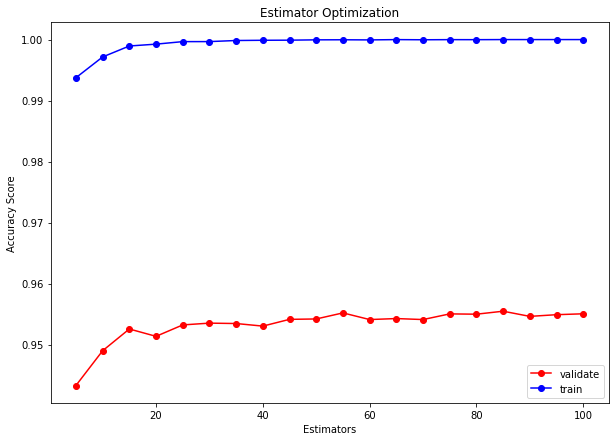

In [132]:
#plotting the accuracy scores for different numbers of estimators
plt.figure(figsize=(10,7))
plt.plot(estimators, RF_validate_accs, color="red", label="validate", marker='o')
plt.plot(estimators, RF_train_accs, color="blue", label="train", marker='o')
plt.ylabel("Accuracy Score")
plt.xlabel("Estimators")
plt.title("Estimator Optimization")
plt.legend()
plt.show()

All of our Random Forest scores are high, but luckily we have a clear "elbow" in the validate scores at 15 estimators. The ~100% accuracy for the training set indicates that the model is probably overfit, but the consistently high validation scores indicate that it may still generalize to our test data. We can check the exact accuracy score for this train and validate pair.

In [135]:
print(f'With 15 estimators, the train score is {round(RF_train_accs[2],2)*100}%\n\
and the validate score is {round(RF_validate_accs[2],2)*100}%.')

With 15 estimators, the train score is 100.0%
and the validate score is 95.0%.


Similar to our single decision tree, we can vary the maximum depth of the tree. Hopefully we will see a clear bend in the scores based on the depth--as is, 100% test accuracy and 95% validate accuracy seems at risk of overfitting. We don't know what the max depth is for our Random Forest Models, so we can use a broader range of depths in our testing, from 1 to 40 in case the depths exceed our single tree's default. We can use 15 estimators in these iterations.

In [137]:
#fitting depths up to 40, setting the n_estimators to 15
train_accs = []
validate_accs = []
depth = range(1, 41)
for i in depth:
    print(f"Working on my model with {i} depth...", end="\r")
    # 1. Instantiate 
    RF_optdepth = RandomForestClassifier(max_depth=i, n_estimators=15)

    # 2. Fit (on the train set)
    RF_optdepth.fit(X_train, y_train)

    # 3. Score (on both sets)
    train_score = RF_optdepth.score(X_train, y_train)
    validate_score = RF_optdepth.score(X_validate, y_validate)
    
    # Add these to the lists
    train_accs.append(train_score)
    validate_accs.append(validate_score)

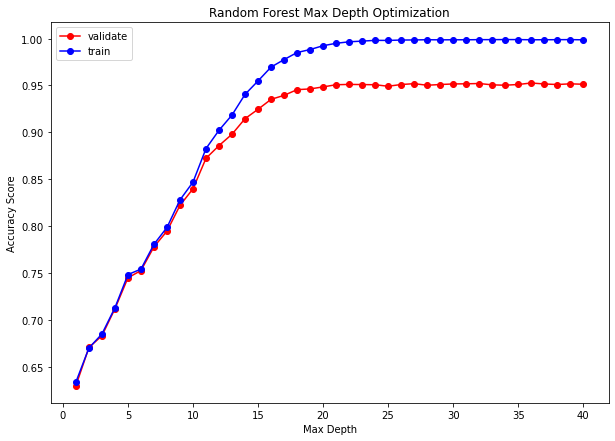

In [138]:
#plotting the accuracy scores at different max depths
plt.figure(figsize=(10,7))
plt.plot(depth, validate_accs, color="red", label="validate", marker='o')
plt.plot(depth, train_accs, color="blue", label="train", marker='o')
plt.ylabel("Accuracy Score")
plt.xlabel("Max Depth")
plt.title("Random Forest Max Depth Optimization")
plt.legend()
plt.show()

The accuracy scores climb in tandem and start to diverge at depths between 15 and 20. We can "zoom in" again in this area and see if an elbow becomes clear.

In [139]:
#setting up list slices that should let us see the depths between 13 and 22
validate_accs_zoomed = validate_accs[13:23]
train_accs_zoomed = train_accs[13:23]
depth_zoomed = depth[13:23]

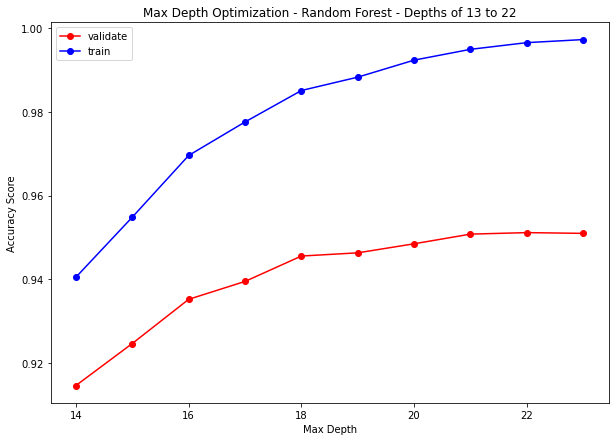

In [140]:
#plot the graph, but focused on the 'elbow' we are seeing in our scores
plt.figure(figsize=(10,7))
plt.plot(depth_zoomed, validate_accs_zoomed, color="red", label="validate", marker='o')
plt.plot(depth_zoomed, train_accs_zoomed, color="blue", label="train", marker='o')
plt.ylabel("Accuracy Score")
plt.xlabel("Max Depth")
plt.title("Max Depth Optimization - Random Forest - Depths of 13 to 22")
plt.legend()
plt.show()

Like we saw when plotting our decision tree depths, there is not an obvious bend to dial in on. 16 appears to be the point where the validate accuracy is growing at a higher rate while still keeping up with the train accuracy.

In [141]:
print(f'With a depth of 16, the train score is {round(train_accs[15],2)*100}%\n\
and the validate score is {round(validate_accs[15],2)*100}%.')

With a depth of 16, the train score is 97.0%
and the validate score is 94.0%.


We have tuned our model to use a depth of 16 and 15 estimators, we can model using out test data and interpret our results.

In [142]:
#using our optimized n_estimators of 15 and a max_depth of 16 
#for a final run with the full training and the test data
#instantiate
OptRF_model = RandomForestClassifier(max_depth=16, n_estimators=15)

#fit
OptRF_model.fit(X_fulltrain, y_fulltrain)

#score
print(f'Train Score: {OptRF_model.score(X_fulltrain, y_fulltrain)}')
print(f'Validate Score: {OptRF_model.score(X_test, y_test)}')

Train Score: 0.9666226955898638
Validate Score: 0.9399723149580653


Our optimized model generalized well to our test data and delivered similar scores as our training and validation sets. We can check our results with another confusion matrix and see how our Recall and Precision compare to the Decision Tree's scores.

In [143]:
# Get class predictions
y_pred = OptRF_model.predict(X_test)

# Generate a basic confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[31293,  1268],
       [ 2418, 26426]], dtype=int64)

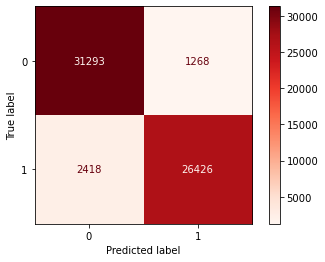

In [144]:
#plotting the confusion matrix
plot_confusion_matrix(OptRF_model, X_test, y_test, cmap='Reds');

In [145]:
#true negatives, the top left at 30172
tn = cf_matrix[0,0]

#false negatives, bottom left at 3626
fn = cf_matrix[1,0]

#true positives, bottom right at 25218
tp = cf_matrix[1,1]

#false positives, top right at 2389
fp = cf_matrix[0,1]

In [146]:
#getting our precision score
precision = tp/(tp+fp)

print(f"Our model's Precision is {tp}/{tp+fp}, or {round(precision*100, 2)}%")

Our model's Precision is 26426/27694, or 95.42%


In [147]:
#getting our recall score
precision = tp/(tp+fn)

print(f"Our model's Recall is {tp}/{tp+fn}, or {round(precision*100, 2)}%")

Our model's Recall is 26426/28844, or 91.62%


Our Decision tree model set a high bar, but our Random Forest model was able to improve our results despite that. Our model's Accuracy, Precision, and Recall are all **over 91%**, a modest improvement on the Decision Tree.

To summarize, the Random Forest model **accurately classifies instances where the observed county is in a week of drought 94% of the time.** 

The model **identifies- or recalls- 92% of the county-weeks** that are **in fact in drought** as a county-week in drought. Finally, our model is precise--**95% of the county-weeks that it predicted as being in drought are in fact in drought.

Although we can't interpret a single tree of decisions for our random forest model, we *can* get a sense of the most important features by call the model's feature_importances_ to see how the features rank in their decision making utility.

In [221]:
#checking the feature importances for the Random Forest
feature_df = pd.DataFrame(
    {"Feature":X_test.columns,
     "Random Forest Importances": OptRF_model.feature_importances_})

feature_df.sort_values(by='Random Forest Importances', ascending=False, ignore_index=True)

,Feature,Random Forest Importances
0,Year,0.161509
1,Long,0.153671
2,Lat,0.124675
3,maxtemp,0.123256
4,Month,0.122390
5,monthly_precip,0.092603
6,total_Sq_Mi,0.048961
7,Acres_operated,0.047473
8,yearly_conv_input_exp,0.045797
9,Day,0.040870


The initial branches in many of our Random Forest's trees may be fairly similar to our Decision Tree. 

**Year and Longitude are the top two features at 16% and 15% respectively.** Latitude, Month, and Max Temperature were similar in their importance at 12%, roughly tied for third. Monthly Precipitation has an imortance of 9%, and every other feature has less than a 5% share of the decision-importance.

Our Random Forest model, like the Decision Tree, is primarily using geography, years, and seasonality to predict if the county-week observations are in drought or not in drought. Weather patterns are secondary, with agricultural data as a more distant determiner of drought or lack thereof.

We can circle back on the Decision Tree plot and see if we can pick out the Conventional Agriculture input expenses feature a bit deeper into the tree plot.

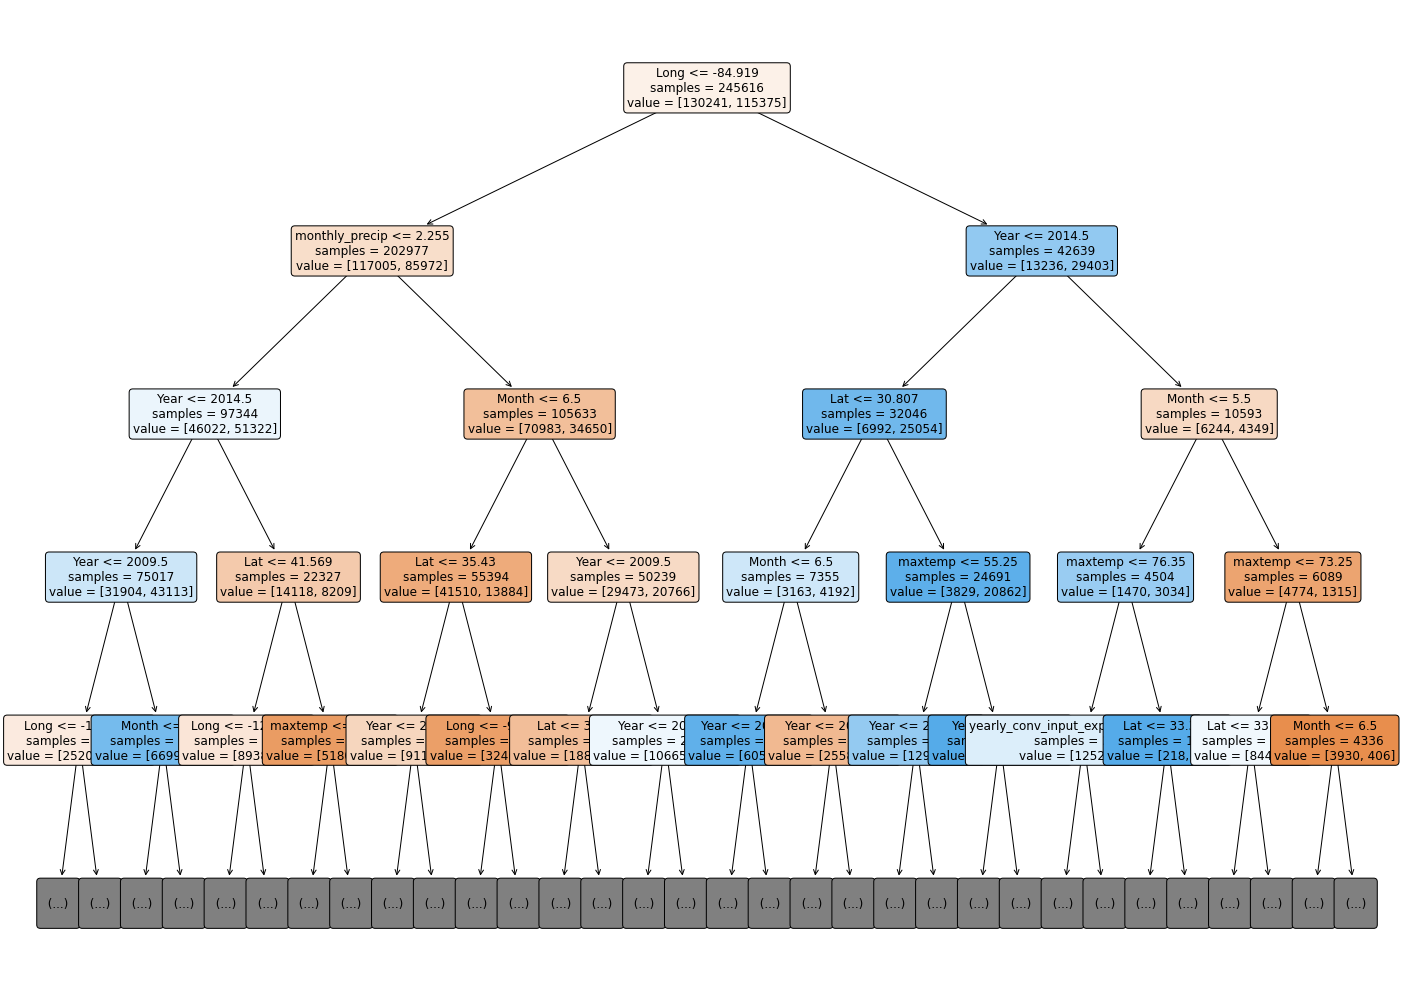

In [153]:
#trying a depth of four to spot our yearly_conv_input_exp
fig, ax = plt.subplots(figsize=(24,18))

plot_tree(DT_modeltest,
          max_depth=4,
          feature_names=X_test.columns,
          rounded=True,
          impurity=False,
          filled=True,
          ax=ax,
          fontsize=12);

**We have yearly_conv_input_exp making an appearance at a depth of 4. This points to it lacking importance.** So far we have two results that run counter to what we found in our less-accurate Logistic Regression. This does not bode well for our initial hypothesis about conventional agriculture relating to drought, but we will attempt one more model before making conclusions regarding our features: a Gradient Boosting model.

## Gradient Boosting
---
The last model we will attempt is a Gradient Boosting (GB) model. GB models iteratively fit sub-models to the residuals of earlier models in an attempt to improve on the data points that it inaccurately classified. In short, GB models use their 'mistakes' to improve their modeling accuracy. 

GB models are an ensemble model that is aggregating the results of many decision trees. These decision trees are often "short", with smaller max depths. We can see some overfitting in GB, but that overfitting is more likely to come from having too many estimators instead of max depths. One main difference between GB and random forest is that GB is using *regression* decision trees, instead of classification decision trees. These regression trees are predicting a linear, continuous target for both the positive, "in drought" category, and the negative "not in drought" category.

Like Random Forests, we can adjust the max depth of the estimators, and the number of estimators used. The main addition that we will vary as we optimize the model is the learning_rate hyperparameter. This controls the contribution of each tree, with smaller learning rates resulting in slower "learning" in the model. 

In [202]:
#importing boosting
from sklearn.ensemble import GradientBoostingClassifier

#running with the defaults set up:
# no limit to the max depth, a learning rate of .1 and 100 estimators ("Trees")
#instantiate
GB_model = GradientBoostingClassifier(verbose=1)

#fit
GB_model.fit(X_train, y_train)

#score
print(f'Train Score: {GB_model.score(X_train, y_train)}')
print(f'Validate Score: {GB_model.score(X_validate, y_validate)}')

      Iter       Train Loss   Remaining Time 
         1           1.3577           28.72s
         2           1.3368           28.43s
         3           1.3195           27.94s
         4           1.2918           27.27s
         5           1.2684           26.83s
         6           1.2555           26.57s
         7           1.2377           26.11s
         8           1.2221           25.72s
         9           1.2121           25.64s
        10           1.2028           25.55s
        20           1.1379           22.94s
        30           1.0968           20.22s
        40           1.0698           17.43s
        50           1.0515           14.63s
        60           1.0361           11.77s
        70           1.0157            8.77s
        80           1.0001            5.85s
        90           0.9838            2.92s
       100           0.9736            0.00s
Train Score: 0.7698684124812716
Validate Score: 0.7669858641130871


Running our GB model with the defaults has resulted in a well fit model--**the train a validate scores are within half a percent of each other at 77% and 76.7%** Although the first pass is not as accurate as our Decision Tree or Random Forest models, it should generalize well. Instead of performing some manual hyperparameter tuning on one or two parameters, we will proceed with a grid search cross-validation of the model. 

This grid search will involve splitting our training data into 4 subsets of data that are cross-validated after we model with them: we get the average accuracy score from the four subsets. This modeling is done with different combinations of hyperparameters applied to the 4 subsets. 

We will test the GB model using four setting for three different hyperparameters:

* n_estimators: 20, 40, 80, 160
* max_depth: 1, 2, 3, 4
* learning_rate: .01, .1, 1, 10

This method of tuning hyperparameters is exhaustive and computationally expensive--but we can be more confident that we have dialed in our model's potential.

In [206]:
# tune n_estimators of 20, 40, 80, 160 max depth of 1, 2, 3, 4, and a learning rate of .01, .1, 1, 10
from sklearn.model_selection import GridSearchCV

optGB_model = GradientBoostingClassifier()

param_grid = {'n_estimators': [20, 40, 80, 160], 'max_depth': [1, 2, 3, 4], 'learning_rate': [.01, .1, 1, 10]}
grid_optGB = GridSearchCV(optGB_model, param_grid=param_grid, cv=4, verbose=2)

grid_optGB.fit(X_train, y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=20; total time=   1.6s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=20; total time=   1.6s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=20; total time=   1.5s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=20; total time=   1.6s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=40; total time=   3.1s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=40; total time=   3.1s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=40; total time=   3.1s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=40; total time=   3.1s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=80; total time=   6.3s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=80; total time=   6.3s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=80; total time=   6.3s
[CV] END ...learning_rate=0.01, max_depth=1, n_

[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=40; total time=   8.6s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=40; total time=   8.5s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=40; total time=   8.5s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=80; total time=  17.1s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=80; total time=  17.8s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=80; total time=  17.3s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=80; total time=  17.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=160; total time=  33.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=160; total time=  33.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=160; total time=  33.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=160; total time=  34.0s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=20; total time=   5.6s
[CV] END ....learning_rate=0

[CV] END .....learning_rate=10, max_depth=1, n_estimators=80; total time=   7.3s
[CV] END ....learning_rate=10, max_depth=1, n_estimators=160; total time=  14.6s
[CV] END ....learning_rate=10, max_depth=1, n_estimators=160; total time=  14.5s
[CV] END ....learning_rate=10, max_depth=1, n_estimators=160; total time=  14.5s
[CV] END ....learning_rate=10, max_depth=1, n_estimators=160; total time=  14.6s
[CV] END .....learning_rate=10, max_depth=2, n_estimators=20; total time=   3.0s
[CV] END .....learning_rate=10, max_depth=2, n_estimators=20; total time=   3.1s
[CV] END .....learning_rate=10, max_depth=2, n_estimators=20; total time=   3.0s
[CV] END .....learning_rate=10, max_depth=2, n_estimators=20; total time=   3.1s
[CV] END .....learning_rate=10, max_depth=2, n_estimators=40; total time=   6.1s
[CV] END .....learning_rate=10, max_depth=2, n_estimators=40; total time=   6.2s
[CV] END .....learning_rate=10, max_depth=2, n_estimators=40; total time=   6.2s
[CV] END .....learning_rate=

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [20, 40, 80, 160]},
             verbose=2)

In [209]:
#score and output the best estimator
print(f'The optimal hyperparameters:{grid_optGB.best_estimator_}')
print(f'Train Score: {grid_optGB.score(X_train, y_train)}')
print(f'Validate Score: {grid_optGB.score(X_validate, y_validate)}')

The optimal hyperparameters:GradientBoostingClassifier(learning_rate=1, max_depth=4, n_estimators=160)
Train Score: 0.9100981477862463
Validate Score: 0.8934108527131783


**Our optimal hyperparameter settings are a learning rate of 1, a max depth of 4, and 160 estimators. We saw plenty of improvement as well, with train and validate accuracy scores reaching 91.0% and 89.3%.**

We can use these settings and run the model with our full training and test data.

In [212]:
#instantiate with our optimal hyperparameters
GB_model_test = GradientBoostingClassifier(learning_rate=1, max_depth=4, n_estimators=160)

#fit
GB_model_test.fit(X_fulltrain, y_fulltrain)

#score
print(f'Full train Score: {GB_model_test.score(X_fulltrain, y_fulltrain)}')
print(f'Test Score: {GB_model_test.score(X_test, y_test)}')

Full train Score: 0.9099570060582373
Test Score: 0.8987053171565833


Our model generalized well and appears to have a good fit--we achieved accuracy scores of **91% for the full training dataset and 90% for the test data.** We can check out our confusion matrix for the model too.

In [213]:
# Get class predictions
y_pred = GB_model_test.predict(X_test)

# Generate a basic confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[29716,  2845],
       [ 3375, 25469]], dtype=int64)

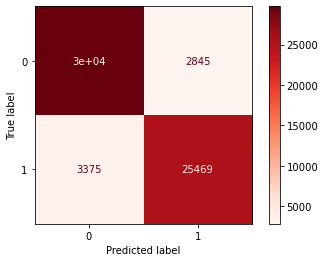

In [214]:
#plotting the confusion matrix
plot_confusion_matrix(GB_model_test, X_test, y_test, cmap='Reds');

In [215]:
#true negatives, the top left at 29716
tn = cf_matrix[0,0]

#false negatives, bottom left at 3375
fn = cf_matrix[1,0]

#true positives, bottom right at 25469
tp = cf_matrix[1,1]

#false positives, top right at 2845
fp = cf_matrix[0,1]

In [216]:
#getting our precision score
precision = tp/(tp+fp)

print(f"Our model's Precision is {tp}/{tp+fp}, or {round(precision*100, 2)}%")

Our model's Precision is 25469/28314, or 89.95%


In [217]:
#getting our recall score
precision = tp/(tp+fn)

print(f"Our model's Recall is {tp}/{tp+fn}, or {round(precision*100, 2)}%")

Our model's Recall is 25469/28844, or 88.3%


Though our Random Forest model outpaced the GB model result, the accuracy, precision, and recall are all still very strong--**like the tuned Decision Tree, the GB model is scoring around 90% for these three measures**

To summarize, the Gradient Boosting model **accurately classifies instances where the observed county is in a week of drought 91% of the time.** 

The model **recalls 88% of the county-weeks** that are **in fact in drought** as a county-week in drought. Finally, our model is precise--**90% of the county-weeks that it predicted as being in drought are in fact in drought.**

Like the Random Forest model, we are not able to output a single tree plot, but we can take a look at the feature importances for our GB model.

In [223]:
#checking the feature importances for the Gradient Boosting model
feature_df = pd.DataFrame(
    {"Feature":X_test.columns,
     "Gradient Boosting Importances": GB_model_test.feature_importances_})

feature_df.sort_values(by='Gradient Boosting Importances', ascending=False, ignore_index=True)

,Feature,Gradient Boosting Importances
0,Year,0.241981
1,Long,0.205710
2,Month,0.141329
3,Lat,0.137623
4,maxtemp,0.104576
5,monthly_precip,0.098660
6,Day,0.018773
7,Acres_operated,0.014048
8,yearly_conv_input_exp,0.013723
9,total_Sq_Mi,0.013205


Not only do our Gradient Boosting model's features have the same order of importance as our Random Forest, but it has greater weights assigned to their importances. 

Year was assigned 24% of the importance, Longitude is again in second and has 20.6% assigned to it, and Month and Latitude are both around 14%. Just like the Random Forest model, we see Maximum temperature and Monthly Precipitation near 10%. 

**The most noticeable difference, however, is that our feature associated with conventional agricultural input costs, yearly_conv_input_exp, has an even lower importance of about 1%.**

With a tuned Decision Tree, Random Forest, and Gradient Boosting model in hand, lets compare the feature_importances for each model. Our logistic regression coefficients are not included mainly because they are not comparable to feature importances. That being said, we know that Monthly Precipitation was by far the strongest coefficient and that conventional ag input expenses was a more distant second. 

Thus far we have seen our Decision Tree, Random Forest, and Gradient Boosting models assign the conventional ag cost feature far less importance. Lets incorporate the feature importances for our Decision Tree model into a dataframe along with the Random Forest and Gradient Boosting numbers.

In [224]:
#checking the feature importances for the Decision Tree, Random Forest, and Gradient Boosting model
feature_df = pd.DataFrame(
    {"Feature":X_test.columns,
     "Decision Tree Importances": DT_modeltest.feature_importances_,
     "Random Forest Importances": OptRF_model.feature_importances_,
     "Gradient Boosting Importances": GB_model_test.feature_importances_})

feature_df

,Feature,Decision Tree Importances,Random Forest Importances,Gradient Boosting Importances
0,total_Sq_Mi,0.009469,0.048961,0.013205
1,Year,0.192322,0.161509,0.241981
2,Month,0.134249,0.122390,0.141329
3,Day,0.043843,0.040870,0.018773
4,monthly_precip,0.080315,0.092603,0.098660
5,maxtemp,0.108073,0.123256,0.104576
6,Acres_operated,0.007967,0.047473,0.014048
7,Operations,0.010730,0.038795,0.010373
8,yearly_conv_input_exp,0.018222,0.045797,0.013723
9,Lat,0.165343,0.124675,0.137623


In [225]:
feature_df['Average Importance Scores'] = ((
    feature_df["Decision Tree Importances"] + 
    feature_df["Random Forest Importances"] + 
    feature_df["Gradient Boosting Importances"])/3)

feature_df

,Feature,Decision Tree Importances,Random Forest Importances,Gradient Boosting Importances,Average Importance Scores
0,total_Sq_Mi,0.009469,0.048961,0.013205,0.023878
1,Year,0.192322,0.161509,0.241981,0.198604
2,Month,0.134249,0.122390,0.141329,0.132656
3,Day,0.043843,0.040870,0.018773,0.034495
4,monthly_precip,0.080315,0.092603,0.098660,0.090526
5,maxtemp,0.108073,0.123256,0.104576,0.111968
6,Acres_operated,0.007967,0.047473,0.014048,0.023163
7,Operations,0.010730,0.038795,0.010373,0.019966
8,yearly_conv_input_exp,0.018222,0.045797,0.013723,0.025914
9,Lat,0.165343,0.124675,0.137623,0.142547


In [227]:
feature_df.sort_values(by='Average Importance Scores', ascending=False, inplace=True, ignore_index=True)
feature_df

,Feature,Decision Tree Importances,Random Forest Importances,Gradient Boosting Importances,Average Importance Scores
0,Year,0.192322,0.161509,0.241981,0.198604
1,Long,0.229466,0.153671,0.205710,0.196283
2,Lat,0.165343,0.124675,0.137623,0.142547
3,Month,0.134249,0.122390,0.141329,0.132656
4,maxtemp,0.108073,0.123256,0.104576,0.111968
5,monthly_precip,0.080315,0.092603,0.098660,0.090526
6,Day,0.043843,0.040870,0.018773,0.034495
7,yearly_conv_input_exp,0.018222,0.045797,0.013723,0.025914
8,total_Sq_Mi,0.009469,0.048961,0.013205,0.023878
9,Acres_operated,0.007967,0.047473,0.014048,0.023163


The Decision Tree model has a slightly different ranking, placing Longitude ahead of Year for its amount of importance. Otherwise the top features remain the same--Latitude, Month and Maximum temperature are all above 10%, trailed closely by monthly precipitation. The conventonal agriculture feature is in the bottom half of import for all three models, pretty conclusively pointing to its relative lack of weight in the predictions that our models were making.

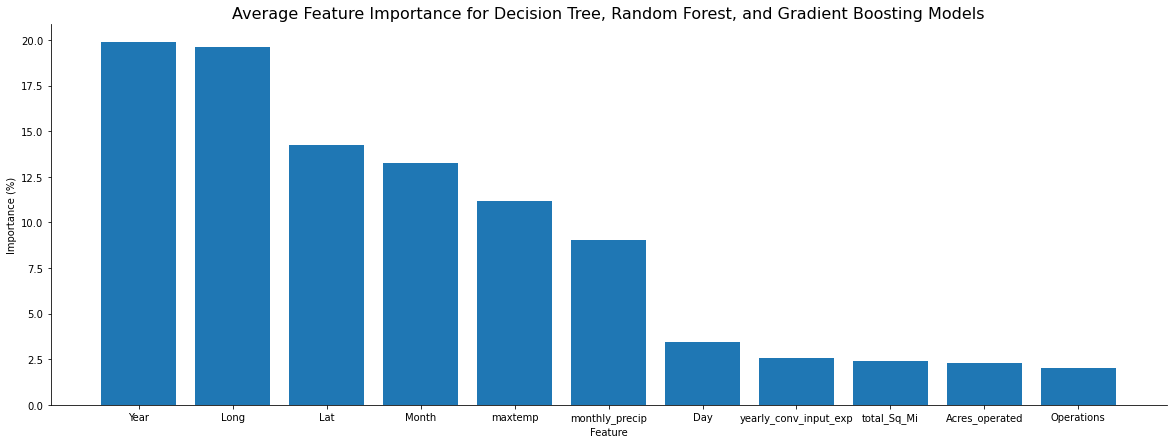

In [233]:
#graphing the average feature importance
plt.figure(figsize=(20, 7))
plt.bar(feature_df['Feature'], feature_df['Average Importance Scores']*100)
plt.title('Average Feature Importance for Decision Tree, Random Forest, and Gradient Boosting Models', fontsize=16)
plt.ylabel('Importance (%)')
plt.xlabel('Feature')
sns.despine()
plt.show()

Conclusions
---


I started the project with a hypothesis, a preconceived notion, really: that states with higher rates of conventional agriculture must have higher drought rates. I thought that my data analysis would uncover some clear trends in that direction. I assumed that the level of conventional agricultural chemical and fertilizer inputs would have *at least* a modest affect in my model's performance.

I was wrong. 

The conventional ag inputs feature was stronger coefficient for our logistic regression, but its utility seems to be limited beyond the logistic regression. It didn't appear in our Decision tree until we hit a depth of four, with a feature importance percent of 2% . It was one of the weaker features for my Random Forest at 4.6% and it was roughly tied for last in the GB model at about 1%. **Overall, Conventional Agricultural Input Expenses** - our operational means of representing higher or lower conventional agriculture practices in a county - **ranked 8th out of 11 features, averaging 2.6% importance**.

**Our final, Random Forest model ultimately had the best performance of all four models, with 94% accuracy.** The Random Forest model also turned in **top precision and recall, at 95% and 92%.**

But the features being used do not lend themselves to *reaction*. The average farmer cannot *react* to signs of drought and change their geography. Knowing that the model uses Year as a high importance feature tells us that *some years have markedly worse drought conditions than others.* But that isn't something that can be *reacted to* until the dry year is upon us.

What our data is telling us is that the best way to weather drought is with proaction. **One way, likely the best way, to proactively improve your odds against drought is to improve the health and water retention of your soil.** Uncovered soil erodes-- blows away, washes away. Without roots to hold the both the soil and water during a dry year, expect losses.

But if you stop tilling, if you use cover crops, if you let biodiversity improve the soil, you stand a better chance when a big drought comes. If you stop relying on using fertilizer to add nutrients, and chemical agents to kipp pests, fungi, or weeds, you can lower your overhead costs as well.

The best way to deal with drought is to be proactive. **Let the soil play its simple part.**